# ETF穿越30日均线

* **买入：**收盘价上穿30日均线
* **卖出：**收盘价下穿30日均线

> 交易价格以每日均价为计算标准；

---

非常简单的策略。但是也只是略高于基准而已。（个人理解好处是可以避免买在山顶上而已，最大回撤降低50%以上）

|    |   基准收益 |   策略收益 |   基准年化收益 |   策略年化收益 |   基准最大回撤 |   策略最大回撤 |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |
|---:|-----------:|-----------:|---------------:|---------------:|---------------:|---------------:|------------------------------------------:|-----------------------------------------------------:|
|  0 |    1.13047 |    1.54166 |       0.144119 |        0.19654 |      -0.696463 |      -0.466368 |                                    2.1761 |                                              2.79722 |

In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import talib
import matplotlib.pyplot as plt
import pandas as pd
from abupy.ExtBu.empyrical import stats

you are using non-interactive mdoel quantaxis


# 原始数据

In [2]:
START='1990-01-01'
END='2019-12-31'
DEFAULT_MA=30
CODE='159915'

def get_data(code, start, end,ma=DEFAULT_MA):
    data=QA.QA_fetch_index_day_adv(code,start=start,end=end)
    if not data:
        return None
    data=data.data.reset_index(level=1, drop=True)
    data['MA']=QA.MA(data['close'],ma)
    data['prev_MA']=data['MA'].shift()#昨天
    data['prev_close']=data['close'].shift()#昨天
    data['prev_bef_MA']=data['MA'].shift(2)#前天
    data['prev_bef_close']=data['close'].shift(2)#前天
    data['date'] = data.index.get_level_values(0)
    data['date'] = pd.to_datetime(data['date'])
    data['avg_price']=(data['close']+data['open']+data['high']+data['low'])/4
    # 星期一为0，星期天为6
    data['weekday'] = data['date'].dt.weekday
    data['nextday']=data['weekday'].shift(-1)
    data['prevday']=data['weekday'].shift()
    return data

In [3]:
data_399006=get_data('399006',start=START,end=END)
data_159915=get_data('159915',start=START,end=END)

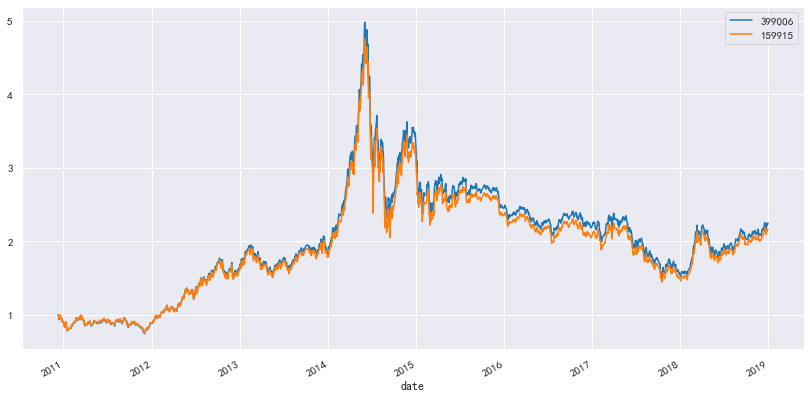

In [4]:
data_close=pd.DataFrame({'399006':data_399006.close,'159915':data_159915.close}).dropna()
(data_close/data_close.iloc[0]).plot()
plt.legend()

In [5]:
data_close.pct_change().describe()

,399006,159915
count,1960.0000,1960.0000
mean,0.0006,0.0006
std,0.0198,0.0219
min,-0.0891,-0.1002
25%,-0.0091,-0.0094
50%,0.0004,0.0000
75%,0.0111,0.0111
max,0.0716,0.1001


In [6]:
data_close.iloc[-1]/data_close.iloc[0]

399006    2.2509
159915    2.1706
dtype: float64

<AxesSubplot:xlabel='date'>

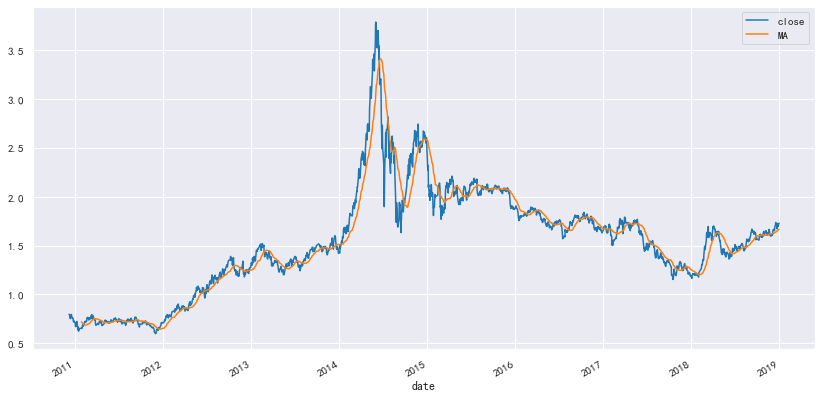

In [7]:
data_159915[['close','MA']].plot()

In [8]:
from gquant.backtest import backtest

def simple_trade_func(data,**kwargs):
    data.loc[(data['prev_close'].shift()>data['prev_MA'].shift())&(data['prev_bef_close'].shift()<data['prev_bef_MA'].shift()),'buy']=1
    data.loc[(data['prev_close'].shift()<data['prev_MA'].shift())&(data['prev_bef_close'].shift()>data['prev_bef_MA'].shift()),'sell']=1
    return data

def simple_buy_price_func(index, row, data):
    return row['avg_price']

def simple_sell_price_func(index, row, data):
    return row['avg_price']

测试多种日线指标

In [9]:
for i in [5,10,20,30,60,120]:
    x = get_data('159915', START, END,ma=i)
    x=simple_trade_func(x)
    m1 = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
                 buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
    print('{}-{}日均线'.format(CODE,i))
    print(m1.stats().to_frame().to_markdown())

1961it [00:01, 1507.58it/s]
0it [00:00, ?it/s]

159915-5日均线
|                                                    |          0 |
|:---------------------------------------------------|-----------:|
| 基准收益                                           |  1.13047   |
| 策略收益                                           |  0.0971017 |
| 基准年化收益                                       |  0.144119  |
| 策略年化收益                                       |  0.0123791 |
| 基准最大回撤                                       | -0.696463  |
| 策略最大回撤                                       | -0.422357  |
| 基准浮动盈亏(基准最后收盘/基准最先开盘)            |  2.1761    |
| 策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |  1.05142   |


1961it [00:00, 2035.25it/s]
0it [00:00, ?it/s]

159915-10日均线
|                                                    |          0 |
|:---------------------------------------------------|-----------:|
| 基准收益                                           |  1.13047   |
| 策略收益                                           |  0.687453  |
| 基准年化收益                                       |  0.144119  |
| 策略年化收益                                       |  0.0876406 |
| 基准最大回撤                                       | -0.696463  |
| 策略最大回撤                                       | -0.444301  |
| 基准浮动盈亏(基准最后收盘/基准最先开盘)            |  2.1761    |
| 策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |  1.52796   |


1961it [00:00, 2482.25it/s]
0it [00:00, ?it/s]

159915-20日均线
|                                                    |         0 |
|:---------------------------------------------------|----------:|
| 基准收益                                           |  1.13047  |
| 策略收益                                           |  0.805645 |
| 基准年化收益                                       |  0.144119 |
| 策略年化收益                                       |  0.102708 |
| 基准最大回撤                                       | -0.696463 |
| 策略最大回撤                                       | -0.472249 |
| 基准浮动盈亏(基准最后收盘/基准最先开盘)            |  2.1761   |
| 策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |  2.13421  |


1961it [00:00, 3025.93it/s]
0it [00:00, ?it/s]

159915-30日均线
|                                                    |         0 |
|:---------------------------------------------------|----------:|
| 基准收益                                           |  1.13047  |
| 策略收益                                           |  1.54166  |
| 基准年化收益                                       |  0.144119 |
| 策略年化收益                                       |  0.19654  |
| 基准最大回撤                                       | -0.696463 |
| 策略最大回撤                                       | -0.466368 |
| 基准浮动盈亏(基准最后收盘/基准最先开盘)            |  2.1761   |
| 策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |  2.79722  |


1961it [00:00, 3381.05it/s]
0it [00:00, ?it/s]

159915-60日均线
|                                                    |          0 |
|:---------------------------------------------------|-----------:|
| 基准收益                                           |  1.13047   |
| 策略收益                                           |  0.776513  |
| 基准年化收益                                       |  0.144119  |
| 策略年化收益                                       |  0.0989945 |
| 基准最大回撤                                       | -0.696463  |
| 策略最大回撤                                       | -0.385236  |
| 基准浮动盈亏(基准最后收盘/基准最先开盘)            |  2.1761    |
| 策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |  1.88159   |


1961it [00:00, 3901.66it/s]

159915-120日均线
|                                                    |          0 |
|:---------------------------------------------------|-----------:|
| 基准收益                                           |  1.13047   |
| 策略收益                                           |  0.236381  |
| 基准年化收益                                       |  0.144119  |
| 策略年化收益                                       |  0.0301353 |
| 基准最大回撤                                       | -0.696463  |
| 策略最大回撤                                       | -0.397509  |
| 基准浮动盈亏(基准最后收盘/基准最先开盘)            |  2.1761    |
| 策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |  1.33497   |


In [13]:
x = get_data('159915', START, END)
x=simple_trade_func(x)
m1 = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
                 buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
print(m1.stats().to_frame().T.to_markdown())

1961it [00:00, 3106.55it/s]


|    |   基准收益 |   策略收益 |   基准年化收益 |   策略年化收益 |   基准最大回撤 |   策略最大回撤 |   基准浮动盈亏(基准最后收盘/基准最先开盘) |   策略浮动盈亏(未结束交易当前价值+剩余现金/初始资金) |
|---:|-----------:|-----------:|---------------:|---------------:|---------------:|---------------:|------------------------------------------:|-----------------------------------------------------:|
|  0 |    1.13047 |    1.54166 |       0.144119 |        0.19654 |      -0.696463 |      -0.466368 |                                    2.1761 |                                              2.79722 |


In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m1.report())

初始资金                     10000.0000
剩余现金                       119.1931
交易次数                        83.0000
未结束交易次数                      1.0000
未结束交易购买金额                26734.0500
未结束交易当前价值                27853.0000
盈利次数                        32.0000
亏损次数                        50.0000
盈利次数占比                       0.3855
盈利(含交易费)次数                  31.0000
亏损(含交易费)次数                  51.0000
盈利(含交易费)次数占比                 0.3735
盈利交易平均获利                  1543.0047
亏损交易平均亏损                  -627.8575
盈利(含交易费)交易平均获利            1592.6565
亏损(含交易费)交易平均亏损            -615.4721
盈亏总额                     17983.2750
手续费总额                     1130.0319
手续费均值                        6.8488
最大盈利%                        1.0466
最大亏损%                       -0.1337
最大(含交易费)盈利%                  1.0457
最大(含交易费)亏损%                 -0.1343
基准浮动盈亏(基准最后收盘/基准最先开盘)        2.1761
结算价值(未结束交易当前价值+剩余现金)     27972.1931
浮动盈亏(结算价值/初始资金)              2.7972
dtype: float64


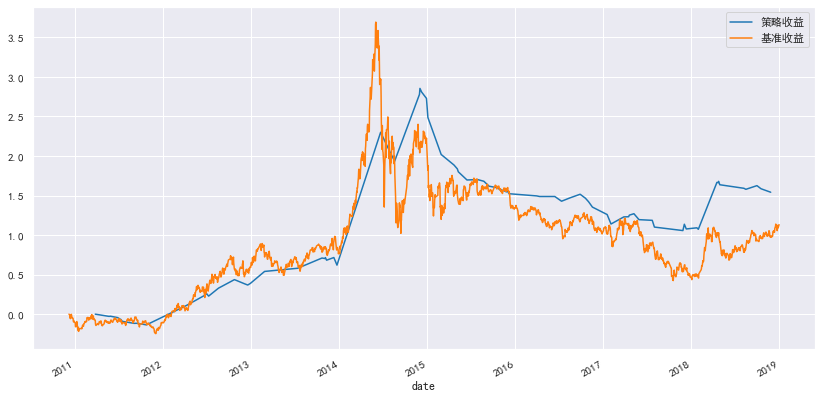

In [15]:
m1.plot_cash()